In [1]:
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
library(car)
library(multcomp)
library(multcompView)
library(ggpubr)

theme_set(ggthemes::theme_few() + theme(text = element_text(size = 14), strip.text = element_text(size = 16)))

options(repr.plot.width=5, repr.plot.height=5)

myColorPalette <- c("#005AB5","#DC3220")

# equation of d15n to atom excess
#### 0.0004x + 0.3683
#### 0.0004x + 0.3727
#### 0.0004x + 0.3690

# Atom excess = 0.0004*d15n_permil + 0.37
d15n_2_ae <- function(x) 0.0004*x + 0.37

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 

In [2]:
# Helper function to check model assumptions   
check_assumptions <- function(mod) {

   print(plot(mod)) # resid x pred
   print(plot(density(resid(mod))))  #A density plot
   # Make sure the residuals are normal
   shapiro.test(residuals(mod)) 
}

## Hancock 2021

In [3]:
uwm21 <- read.csv("./datasets/MOA_21_UWM.csv")[-1]
str(uwm21)


'data.frame':	120 obs. of  8 variables:
 $ location : chr  "Hancock" "Hancock" "Hancock" "Hancock" ...
 $ year     : int  2021 2021 2021 2021 2021 2021 2021 2021 2021 2021 ...
 $ site_year: chr  "Hancock - 2021" "Hancock - 2021" "Hancock - 2021" "Hancock - 2021" ...
 $ sampling : int  1 1 1 1 1 1 1 1 1 1 ...
 $ plot     : int  103 104 107 110 111 113 116 119 121 123 ...
 $ rep      : int  1 1 2 2 3 3 4 4 5 5 ...
 $ treatment: chr  "UTC" "ProveN40" "ProveN40" "UTC" ...
 $ delta15N : num  1110 663 887 987 1286 ...


In [4]:

# To factor
uwm21 <- uwm21 %>% mutate_at(c("location","year","site_year","sampling","plot","rep","treatment"), factor)

#uwm21$delta15N  <- d15n_2_ae(uwm21$delta15N )

# Factor levels 
uwm21$treatment <- factor(uwm21$treatment, levels = c('UTC','ProveN40'),  labels = c('UTC','PROVEN40'))
uwm21$sampling <- factor(uwm21$sampling, levels = 1:5, labels = c("V4","V5","V8","V12","VT"))


In [5]:
# test for HOV across treatments
leveneTest(delta15N ~ treatment, data=uwm21)
leveneTest(delta15N ~ sampling, data=uwm21)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.0142938,0.9050377
,118,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,13.21674,6.852609e-09
,115,NA,NA


In [6]:
leveneTest(log(delta15N) ~ treatment, data=uwm21)
leveneTest(log(delta15N) ~ sampling, data=uwm21)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.2061226,0.6506576
,118,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,5.612126,0.0003662144
,115,NA,NA


In [7]:
uwm21_mod_full <- lmer(log(delta15N) ~ treatment * sampling  + (1|rep/plot), data = uwm21)
uwm21_mod_red <- lmer(log(delta15N) ~ treatment + sampling  + (1|rep/plot), data = uwm21)

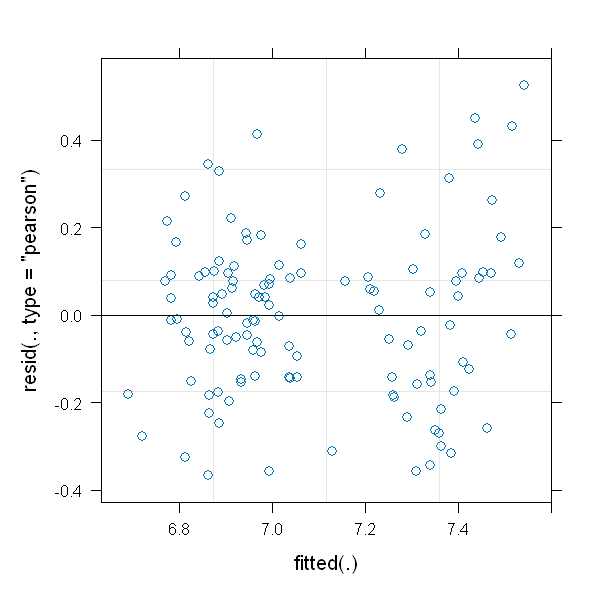

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98101, p-value = 0.08836


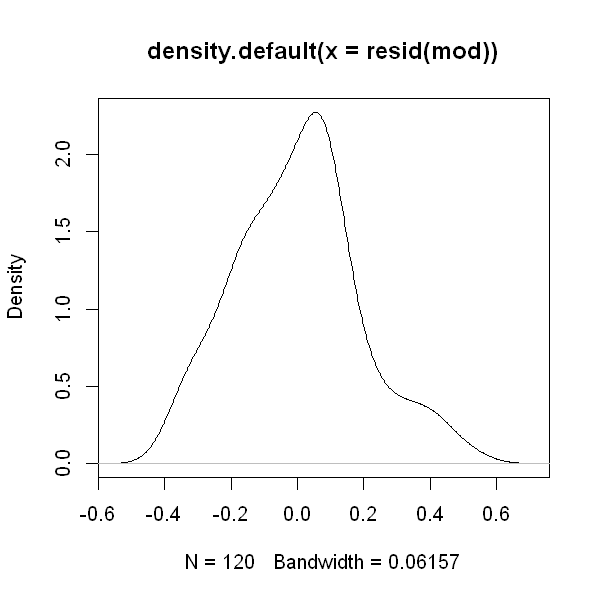

In [8]:
check_assumptions(uwm21_mod_red)

In [9]:
anova(uwm21_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
treatment,0.1466819,0.14668194,1,11.00008,3.709152,8.034168e-02
sampling,5.9630409,1.49076022,4,87.99995,37.696916,2.420366e-18
treatment:sampling,0.2209427,0.05523568,4,87.99995,1.396747,2.416973e-01


In [10]:
anova(uwm21_mod_full,uwm21_mod_red)[1:3]

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC
,<dbl>,<dbl>,<dbl>
uwm21_mod_red,9,-18.13081,6.956619
uwm21_mod_full,13,-16.04004,20.197349


In [11]:
summary(uwm21_mod_red)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(delta15N) ~ treatment + sampling + (1 | rep/plot)
   Data: uwm21

REML criterion at convergence: -9.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.82229 -0.71010  0.00584  0.48063  2.61800 

Random effects:
 Groups   Name        Variance Std.Dev.
 plot:rep (Intercept) 0.003766 0.06137 
 rep      (Intercept) 0.003723 0.06101 
 Residual             0.040228 0.20057 
Number of obs: 120, groups:  plot:rep, 24; rep, 12

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        6.9858038  0.0513369 69.3923399 136.078  < 2e-16 ***
treatmentPROVEN40 -0.0854509  0.0443692 10.9999783  -1.926   0.0803 .  
samplingV5         0.4778048  0.0578994 92.0000411   8.252 1.07e-12 ***
samplingV8         0.0004773  0.0578994 92.0000411   0.008   0.9934    
samplingV12       -0.0907436  0.0578994 92.0000411  -1.567   0.1205    
samplingVT 

$`plot:rep`

$rep


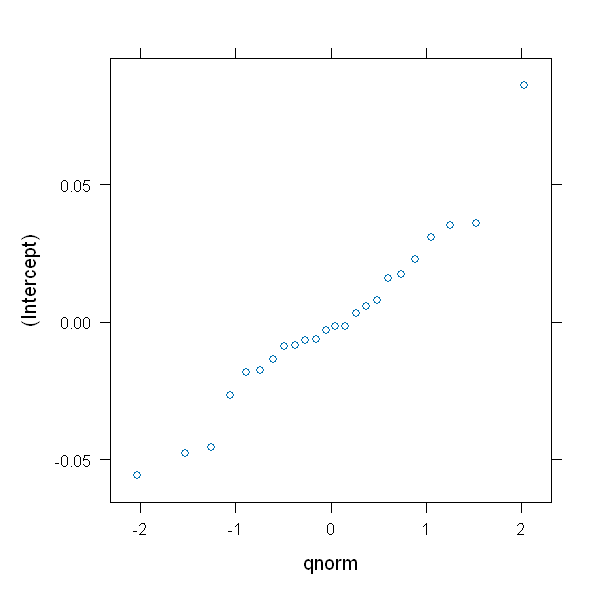

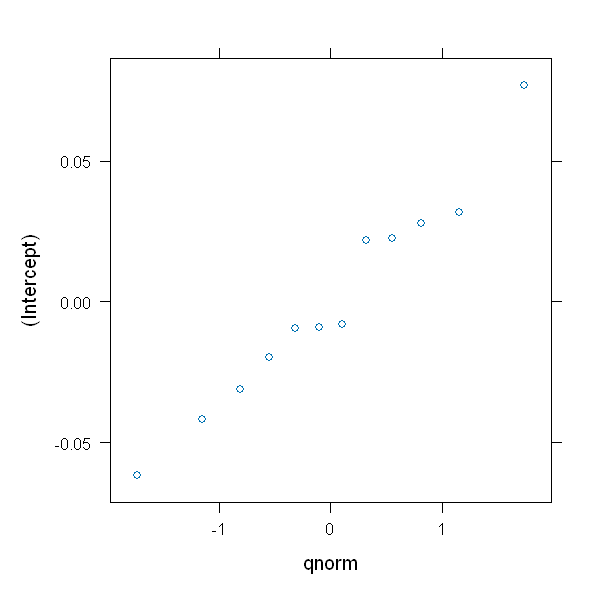

In [12]:
plot(ranef(uwm21_mod_red))

In [13]:
uwm21_mod_red_means <- emmeans(uwm21_mod_red, ~ treatment + sampling, type = "response")
uwm21_mod_red_means

 treatment sampling response   SE   df lower.CL upper.CL
 UTC       V4           1081 55.5 69.4      976     1198
 PROVEN40  V4            993 51.0 69.4      896     1100
 UTC       V5           1743 89.5 69.4     1574     1931
 PROVEN40  V5           1601 82.2 69.4     1445     1773
 UTC       V8           1082 55.5 69.4      976     1198
 PROVEN40  V8            993 51.0 69.4      896     1100
 UTC       V12           987 50.7 69.4      891     1094
 PROVEN40  V12           907 46.5 69.4      818     1004
 UTC       VT           1527 78.4 69.4     1379     1692
 PROVEN40  VT           1402 72.0 69.4     1266     1554

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [14]:
uwm21_mod_red_trt_contrast <- emmeans(uwm21_mod_red, ~ treatment, type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

uwm21_mod_red_trt_contrast

,contrast,ratio,SE,df,null,t.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PROVEN40 / UTC,0.9180982,0.04073525,11,1,-1.925908,0.08034299


In [15]:

my_label <- with(uwm21_mod_red_trt_contrast,
paste0(
    "Ndfa = ",
    signif(1 - ratio,3)*100,
    "%",
    #"(± ",
    #signif(SE,3)*100,
    #"%)",
    "\n",
    "p = ",signif(p.value,3)
    )
)

my_label

[1] "Ndfa = 8.19%\np = 0.0803"

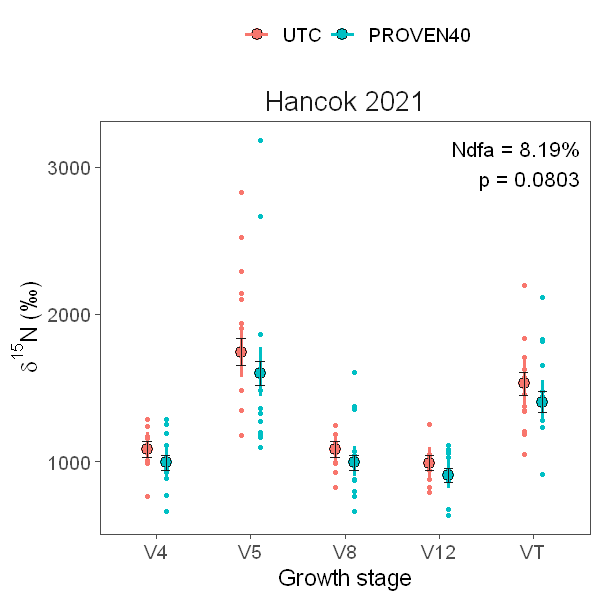

In [16]:
uwm21_plot <- as.data.frame(uwm21_mod_red_means) %>% 
ggplot(aes((sampling),response, colour = treatment, fill = treatment)) + 
geom_point(aes(y = delta15N), data = uwm21, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(position = position_dodge(width = 0.4), size = 3, shape = 21, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
geom_errorbar(aes(ymax = response + SE, ymin = response - SE), colour = "gray10", width = 0.2, position = position_dodge(width = 0.4)) + 
labs(y = expression(delta^15*N~"(‰)"), x = "Growth stage", colour = "", fill = "") + 
annotate("text", x = 5.5, y = max(uwm21$delta15N), label = my_label, hjust = 1, size = 4.5, vjust = 1) + 
facet_wrap(~"Hancok 2021") + 
theme(legend.position = "top")

uwm21_plot

# 2022 Trials

In [17]:
uwm22 <- read.csv("./datasets/MOA_22_UWM.csv")[-1]
str(uwm22)


'data.frame':	900 obs. of  8 variables:
 $ location : chr  "Arlington" "Arlington" "Arlington" "Arlington" ...
 $ year     : int  2022 2022 2022 2022 2022 2022 2022 2022 2022 2022 ...
 $ site_year: chr  "Arlington - 2022" "Arlington - 2022" "Arlington - 2022" "Arlington - 2022" ...
 $ sampling : int  1 2 3 4 5 1 2 3 4 5 ...
 $ plot     : int  101 101 101 101 101 101 101 101 101 101 ...
 $ rep      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ treatment: chr  "UTC" "UTC" "UTC" "UTC" ...
 $ delta15N : num  1487 1208 975 881 875 ...


## 2022 Arlington

In [18]:
uwm22a <- uwm22 %>%  filter(location  == "Arlington", treatment	!= "nifKO") %>% 
mutate_at(c("location","year","site_year","sampling","plot","rep","treatment"), factor)

#uwm22a$delta15N  <- d15n_2_ae(uwm22a$delta15N )


# Factor levels 
uwm22a$treatment <- factor(uwm22a$treatment, levels = c('UTC','ProveN40'),  labels = c('UTC','PROVEN40'))
uwm22a$sampling <- factor(uwm22a$sampling, levels = 1:5, labels = c("V5","V7","V9","V14","VT"))

str(uwm22a)

'data.frame':	300 obs. of  8 variables:
 $ location : Factor w/ 1 level "Arlington": 1 1 1 1 1 1 1 1 1 1 ...
 $ year     : Factor w/ 1 level "2022": 1 1 1 1 1 1 1 1 1 1 ...
 $ site_year: Factor w/ 1 level "Arlington - 2022": 1 1 1 1 1 1 1 1 1 1 ...
 $ sampling : Factor w/ 5 levels "V5","V7","V9",..: 1 2 3 4 5 1 2 3 4 5 ...
 $ plot     : Factor w/ 60 levels "101","103","201",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ rep      : Factor w/ 30 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ treatment: Factor w/ 2 levels "UTC","PROVEN40": 1 1 1 1 1 2 2 2 2 2 ...
 $ delta15N : num  1487 1208 975 881 875 ...


In [19]:
# test for HOV across treatments
leveneTest(delta15N ~ treatment, data=uwm22a)
leveneTest(delta15N ~ sampling, data=uwm22a)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.1182997,0.7311285
,298,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,17.66037,5.222037e-13
,295,NA,NA


In [20]:
# test for HOV across treatments
leveneTest(log(delta15N) ~ treatment, data=uwm22a)
leveneTest(log(delta15N) ~ sampling, data=uwm22a)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.007139797,0.9327178
,298,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,2.751036,0.02841844
,295,NA,NA


In [21]:
uwm22a_mod_full <- lmer(log(delta15N) ~ treatment * sampling  + (1|rep/plot), data = uwm22a)
uwm22a_mod_red <- lmer(log(delta15N) ~ treatment + sampling  + (1|rep/plot), data = uwm22a)

In [22]:
anova(uwm22a_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
treatment,0.004262355,0.004262355,1,29,0.9768714,3.311477e-01
sampling,15.269886090,3.817471522,4,232,874.9103888,1.249598e-138
treatment:sampling,0.016847046,0.004211761,4,232,0.9652761,4.272802e-01


In [23]:
anova(uwm22a_mod_full,uwm22a_mod_red)[1:3]

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC
,<dbl>,<dbl>,<dbl>
uwm22a_mod_red,9,-656.4603,-623.1263
uwm22a_mod_full,13,-652.4217,-604.2725


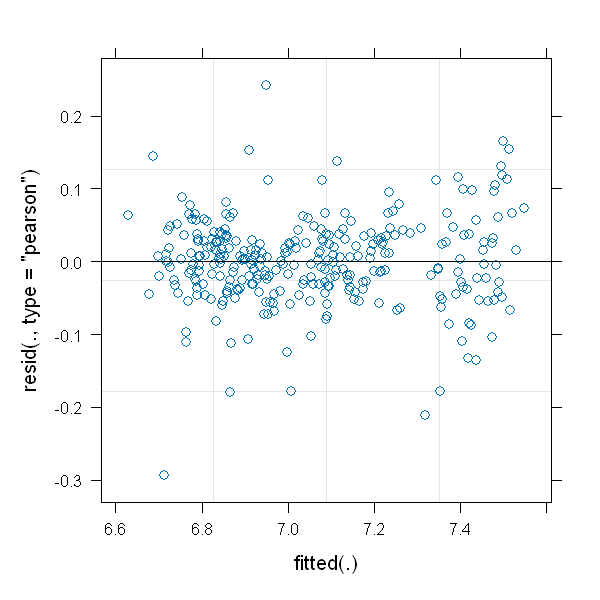

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.95994, p-value = 2.416e-07


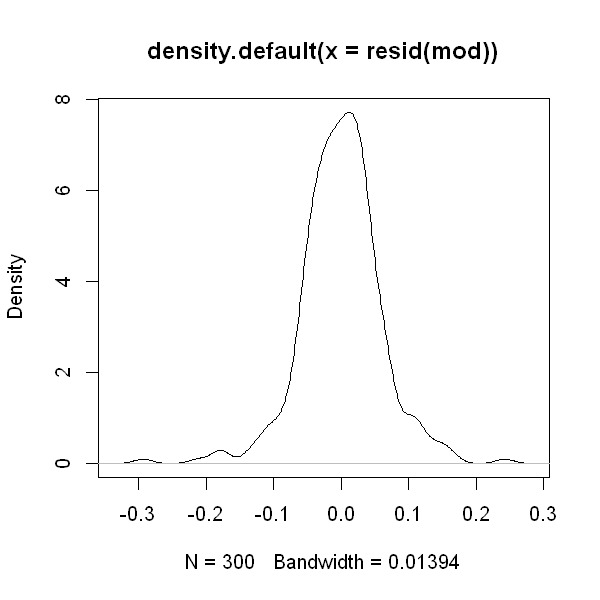

In [24]:
check_assumptions(uwm22a_mod_red)

In [25]:
summary(uwm22a_mod_full)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(delta15N) ~ treatment * sampling + (1 | rep/plot)
   Data: uwm22a

REML criterion at convergence: -612

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4047 -0.4672  0.0073  0.4965  3.5934 

Random effects:
 Groups   Name        Variance  Std.Dev.
 plot:rep (Intercept) 0.0038229 0.06183 
 rep      (Intercept) 0.0009045 0.03007 
 Residual             0.0043633 0.06606 
Number of obs: 300, groups:  plot:rep, 60; rep, 30

Fixed effects:
                                Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                     7.441137   0.017407 136.074206 427.468   <2e-16
treatmentPROVEN40              -0.027409   0.023361  82.447810  -1.173    0.244
samplingV7                     -0.258192   0.017055 232.000002 -15.138   <2e-16
samplingV9                     -0.411093   0.017055 232.000002 -24.103   <2e-16
samplingV14                    -0.579270   0.017

In [26]:
summary(uwm22a_mod_red)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(delta15N) ~ treatment + sampling + (1 | rep/plot)
   Data: uwm22a

REML criterion at convergence: -631.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4413 -0.5016  0.0314  0.4817  3.6635 

Random effects:
 Groups   Name        Variance  Std.Dev.
 plot:rep (Intercept) 0.0038234 0.06183 
 rep      (Intercept) 0.0009044 0.03007 
 Residual             0.0043607 0.06604 
Number of obs: 300, groups:  plot:rep, 60; rep, 30

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)         7.43618    0.01565  95.01645 475.267   <2e-16 ***
treatmentPROVEN40  -0.01749    0.01769  28.99948  -0.988    0.331    
samplingV7         -0.26249    0.01206 235.99979 -21.772   <2e-16 ***
samplingV9         -0.40158    0.01206 235.99979 -33.308   <2e-16 ***
samplingV14        -0.56230    0.01206 235.99979 -46.639   <2e-16 ***
samplingVT         -0.6309

In [27]:
uwm22a_mod_red_means <- emmeans(uwm22a_mod_red, ~ treatment + sampling, type = "response")
uwm22a_mod_red_means

 treatment sampling response   SE df lower.CL upper.CL
 UTC       V5           1696 26.5 95     1644     1750
 PROVEN40  V5           1667 26.1 95     1616     1719
 UTC       V7           1305 20.4 95     1265     1346
 PROVEN40  V7           1282 20.1 95     1243     1322
 UTC       V9           1135 17.8 95     1101     1171
 PROVEN40  V9           1116 17.5 95     1081     1151
 UTC       V14           967 15.1 95      937      997
 PROVEN40  V14           950 14.9 95      921      980
 UTC       VT            903 14.1 95      875      931
 PROVEN40  VT            887 13.9 95      860      915

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [28]:
uwm22a_mod_red_trt_contrast <- emmeans(uwm22a_mod_red, ~ treatment, type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

uwm22a_mod_red_trt_contrast

,contrast,ratio,SE,df,null,t.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PROVEN40 / UTC,0.982665,0.01738607,29,1,-0.988368,0.3311477


In [29]:
my_label <- with(uwm22a_mod_red_trt_contrast,

paste0(
    "Ndfa = ",
    signif(1 - ratio,3)*100,
    "%",
    #"(± ",
    #signif(SE,3)*100,
    #"%)",
    "\n",
    "p-value = ",signif(p.value,3)
    )
)

my_label

[1] "Ndfa = 1.73%\np-value = 0.331"

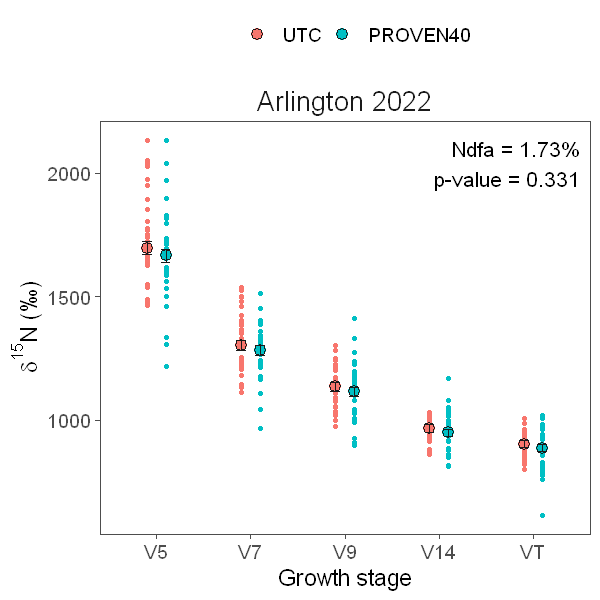

In [30]:
uwm22a_plot <- as.data.frame(uwm22a_mod_red_means) %>% 
ggplot(aes((sampling),response, colour = treatment, fill = treatment)) + 
geom_point(aes(y = delta15N), data = uwm22a, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(position = position_dodge(width = 0.4), size = 3, shape = 21, colour = "gray10") +
geom_errorbar(aes(ymax = response + SE, ymin = response - SE), colour = "gray10", width = 0.2, position = position_dodge(width = 0.4)) + 
labs(y = expression(delta^15*N~"(‰)"), x = "Growth stage", colour = "", fill = "") + 
annotate("text", x = 5.5, y = max(uwm22a$delta15N), label = my_label, hjust = 1, size = 4.5, vjust = 1) + 
facet_wrap(~"Arlington 2022") + 
theme(legend.position = "top")

uwm22a_plot

## 2022 Hancok

In [31]:
uwm22h <- uwm22 %>%  filter(location  == "Hancock", treatment	!= "nifKO"
) %>% 
mutate_at(c("location","year","site_year","sampling","plot","rep","treatment"), factor)

#uwm22h$delta15N  <- d15n_2_ae(uwm22h$delta15N )

str(uwm22h)

# Factor levels 
uwm22h$treatment <- factor(uwm22h$treatment, levels = c('UTC','ProveN40'),  labels = c('UTC','PROVEN40'))
uwm22h$sampling <- factor(uwm22h$sampling, levels = 1:5, labels = c("V5","V7","V10","VT","R1"))


'data.frame':	300 obs. of  8 variables:
 $ location : Factor w/ 1 level "Hancock": 1 1 1 1 1 1 1 1 1 1 ...
 $ year     : Factor w/ 1 level "2022": 1 1 1 1 1 1 1 1 1 1 ...
 $ site_year: Factor w/ 1 level "Hancock - 2022": 1 1 1 1 1 1 1 1 1 1 ...
 $ sampling : Factor w/ 5 levels "1","2","3","4",..: 1 2 3 4 5 1 2 3 4 5 ...
 $ plot     : Factor w/ 60 levels "102","103","202",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ rep      : Factor w/ 30 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ treatment: Factor w/ 2 levels "ProveN40","UTC": 2 2 2 2 2 1 1 1 1 1 ...
 $ delta15N : num  1385 1221 1067 1210 1244 ...


In [32]:
# test for HOV across treatments
leveneTest(delta15N ~ treatment, data=uwm22h)
leveneTest(delta15N ~ sampling, data=uwm22h)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,1.823065,0.1779734
,298,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,13.1591,7.091654e-10
,295,NA,NA


In [33]:
leveneTest(log(delta15N) ~ treatment, data=uwm22h)
leveneTest(log(delta15N) ~ sampling, data=uwm22h)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,2.003973,0.1579318
,298,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,11.28142,1.567303e-08
,295,NA,NA


In [34]:
uwm22h_mod_full <- lmer(log(delta15N) ~ treatment * sampling  + (1|rep/plot), data = uwm22h)
uwm22h_mod_red <- lmer(log(delta15N) ~ treatment + sampling  + (1|rep/plot), data = uwm22h)

In [35]:
anova(uwm22h_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
treatment,0.005701077,0.005701077,1,29,0.8966443,3.515071e-01
sampling,1.773827227,0.443456807,4,232,69.7452438,1.071739e-38
treatment:sampling,0.035803923,0.008950981,4,232,1.4077771,2.321242e-01


In [36]:
anova(uwm22h_mod_full,uwm22h_mod_red)[1:3]

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC
,<dbl>,<dbl>,<dbl>
uwm22h_mod_red,9,-569.3698,-536.0357
uwm22h_mod_full,13,-567.1255,-518.9763


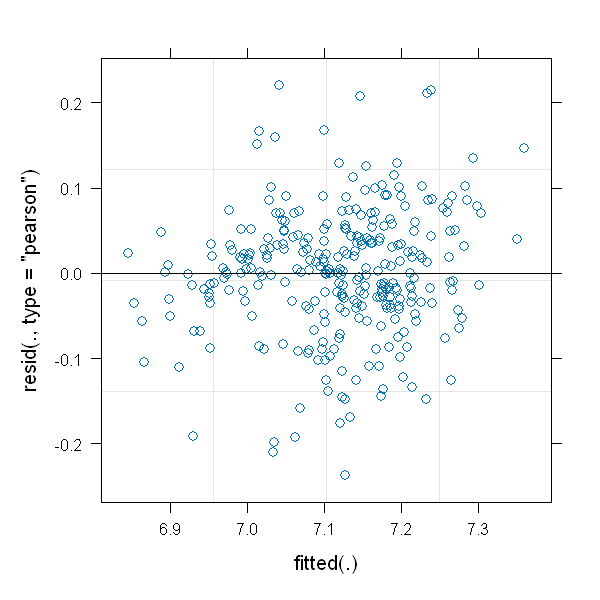

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98641, p-value = 0.006293


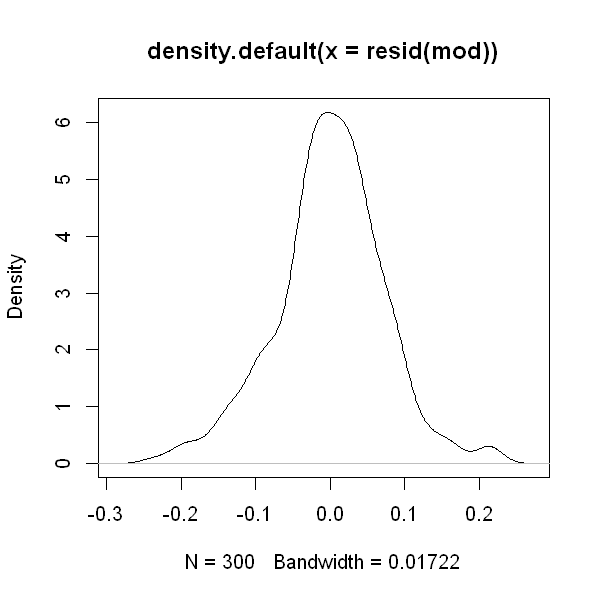

In [37]:
check_assumptions(uwm22h_mod_red)

In [38]:
summary(uwm22h_mod_red)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(delta15N) ~ treatment + sampling + (1 | rep/plot)
   Data: uwm22h

REML criterion at convergence: -546

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.96019 -0.47418  0.01386  0.52828  2.75375 

Random effects:
 Groups   Name        Variance Std.Dev.
 plot:rep (Intercept) 0.001538 0.03922 
 rep      (Intercept) 0.003166 0.05627 
 Residual             0.006402 0.08001 
Number of obs: 300, groups:  plot:rep, 60; rep, 30

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)         7.21891    0.01688  89.26076 427.725  < 2e-16 ***
treatmentPROVEN40  -0.01298    0.01371  29.00004  -0.947    0.352    
samplingV7         -0.06554    0.01461 235.99998  -4.487 1.13e-05 ***
samplingV10        -0.23454    0.01461 235.99998 -16.055  < 2e-16 ***
samplingVT         -0.08563    0.01461 235.99998  -5.861 1.54e-08 ***
samplingR1         -0.

In [39]:
uwm22h_mod_red_means <- emmeans(uwm22h_mod_red, ~ treatment * sampling, type = "response")
uwm22h_mod_red_means

 treatment sampling response   SE   df lower.CL upper.CL
 UTC       V5           1365 23.0 89.3     1320     1412
 PROVEN40  V5           1347 22.7 89.3     1303     1393
 UTC       V7           1278 21.6 89.3     1236     1322
 PROVEN40  V7           1262 21.3 89.3     1220     1305
 UTC       V10          1080 18.2 89.3     1044     1116
 PROVEN40  V10          1066 18.0 89.3     1031     1102
 UTC       VT           1253 21.1 89.3     1212     1296
 PROVEN40  VT           1237 20.9 89.3     1196     1279
 UTC       R1           1255 21.2 89.3     1213     1298
 PROVEN40  R1           1239 20.9 89.3     1198     1281

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [40]:
uwm22h_mod_red_trt_contrast <- emmeans(uwm22h_mod_red, ~ treatment, type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

uwm22h_mod_red_trt_contrast

,contrast,ratio,SE,df,null,t.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PROVEN40 / UTC,0.9871036,0.0135312,29,1,-0.9469135,0.3515069


In [41]:
my_label <- with(uwm22h_mod_red_trt_contrast,

paste0(
    "Ndfa = ",
    signif(1 - ratio,3)*100,
    "% ",
    #"(± ",
    #signif(SE,3)*100,
    #"%)",
    "\n",
    "p-value = ",signif(p.value,3)
    )
)

my_label

[1] "Ndfa = 1.29% \np-value = 0.352"

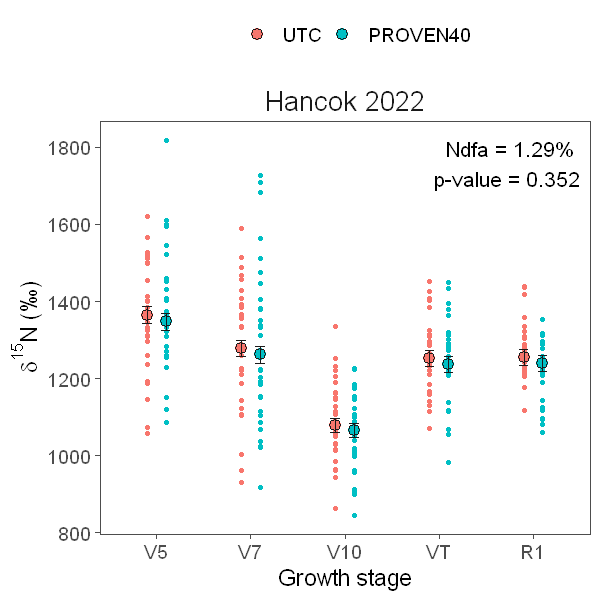

In [42]:
uwm22h_plot <- as.data.frame(uwm22h_mod_red_means) %>% 
ggplot(aes((sampling),response, colour = treatment, fill = treatment)) + 
geom_point(aes(y = delta15N), data = uwm22h, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(position = position_dodge(width = 0.4), size = 3, shape = 21, colour = "gray10") +
geom_errorbar(aes(ymax = response + SE, ymin = response - SE), colour = "gray10", width = 0.2, position = position_dodge(width = 0.4)) + 
labs(y = expression(delta^15*N~"(‰)"), x = "Growth stage", colour = "", fill = "") + 
annotate("text", x = 5.5, y = max(uwm22h$delta15N), label = my_label, hjust = 1, size = 4.5, vjust = 1) + 
facet_wrap(~"Hancok 2022") + 
theme(legend.position = "top")

uwm22h_plot

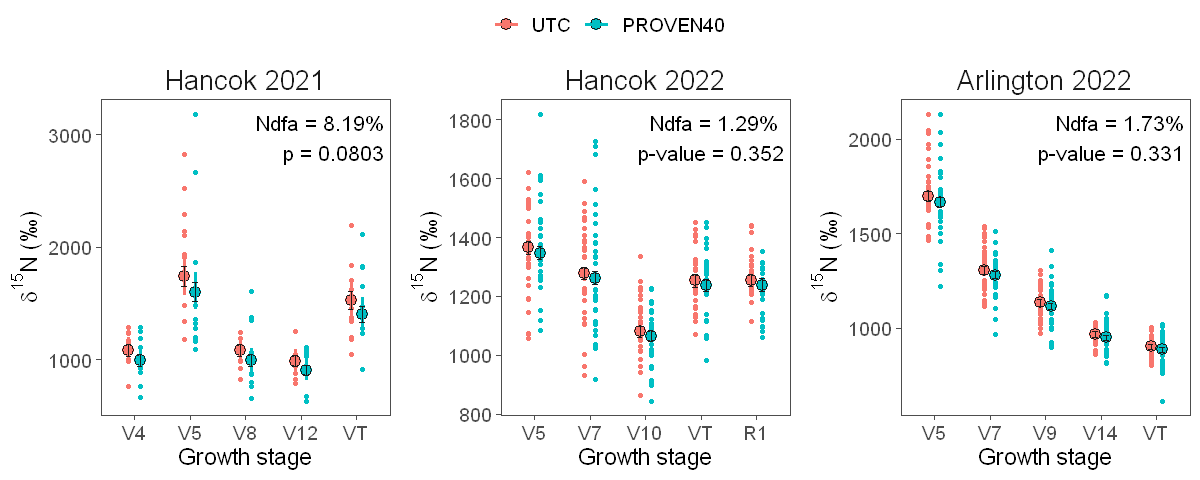

In [43]:
options(repr.plot.width=10, repr.plot.height=4)

ggarrange(uwm21_plot,uwm22h_plot,uwm22a_plot, nrow = 1 , common.legend = T)

In [44]:
uwm_all <- data.frame(emmeans(uwm21_mod_red, ~ treatment, type = "response")) %>% mutate(site_year = "Hancock 2021") %>%
bind_rows(data.frame(emmeans(uwm22h_mod_red, ~ treatment, type = "response")) %>% mutate(site_year = "Hancock 2022")) %>%
bind_rows(data.frame(emmeans(uwm22a_mod_red, ~ treatment, type = "response")) %>% mutate(site_year = "Arlington 2022"))

uwm_all$site_year <- factor(uwm_all$site_year, levels = c("Hancock 2021","Hancock 2022","Arlington 2022")) 

uwm_all_trt_contrasts <- uwm21_mod_red_trt_contrast %>% mutate(site_year = "Hancock 2021") %>% 
bind_rows(uwm22h_mod_red_trt_contrast %>% mutate(site_year = "Hancock 2022")) %>% 
bind_rows(uwm22a_mod_red_trt_contrast %>% mutate(site_year = "Arlington 2022")) %>% 
mutate(my_label = paste0(
    "Ndfa = ",
    signif(1 - ratio,3)*100,
    "% ",
    #"(± ",
    #signif(SE,3)*100,
    #"%)",
    "\n",
    "p-value = ",signif(p.value,3)
    )
)

uwm_all_trt_contrasts$site_year <- factor(uwm_all_trt_contrasts$site_year, levels = c("Hancock 2021","Hancock 2022","Arlington 2022")) 


In [45]:
uwm_all

treatment,response,SE,df,lower.CL,upper.CL,site_year
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
UTC,1251.909,45.04337,20.80517,1161.605,1349.233,Hancock 2021
PROVEN40,1149.376,41.35423,20.80517,1066.468,1238.728,Hancock 2021
UTC,1242.556,17.54980,45.31748,1207.714,1278.404,Hancock 2022
PROVEN40,1226.531,17.32347,45.31748,1192.138,1261.917,Hancock 2022
UTC,1169.954,15.98451,56.52562,1138.374,1202.411,Arlington 2022
PROVEN40,1149.673,15.70742,56.52562,1118.641,1181.567,Arlington 2022


Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = treatment), :
"Ignoring unknown aesthetics: fill"


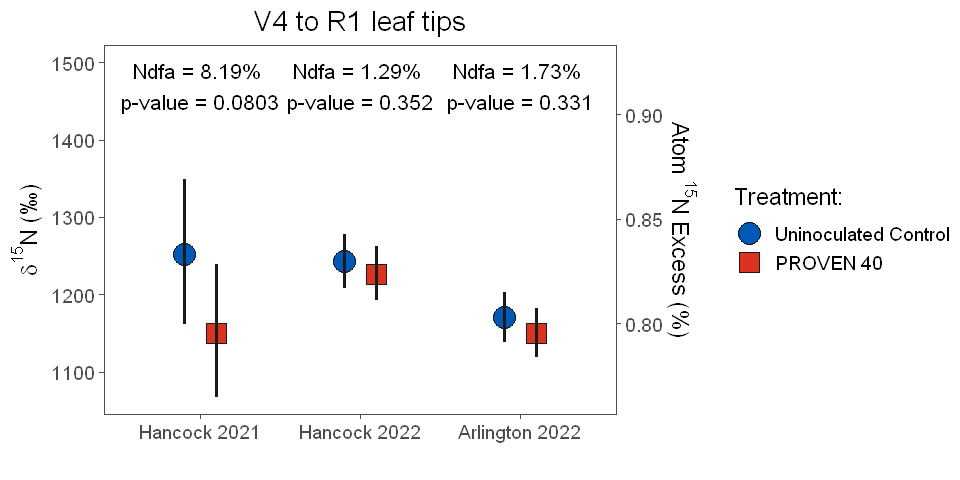

In [46]:
options(repr.plot.width=8, repr.plot.height=4)

uwm_all %>%
ggplot(aes(site_year, response,)) + 
geom_point(aes( fill = treatment, shape = treatment), position = position_dodge(width = 0.4), size = 6, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin =lower.CL, fill = treatment), colour = "gray10", position = position_dodge(width = 0.4), width = 0, lwd = 1) + 
labs(y = expression(delta^15*N~"(‰)"), x = "", fill = "Treatment:", shape = "Treatment:", title = "V4 to R1 leaf tips") + 
geom_text(aes(y = 1500, label = my_label), data = uwm_all_trt_contrasts, size = 4.5, vjust = 1) + 
scale_shape_manual(values = 21:22, labels = c("Uninoculated Control","PROVEN 40")) + 
scale_fill_manual(values = myColorPalette, labels = c("Uninoculated Control","PROVEN 40")) +
scale_y_continuous(sec.axis = sec_axis(~ (.*0.00037 + 0.37), name = expression(Atom~""^15*N~Excess~"(%)"))) + 
theme(legend.position = "right", plot.title = element_text(hjust = 0.5))


In [47]:
ggsave("./figures/uwm_d15n_enrichment_dilution.jpeg", dpi = 300, width= 9, height = 4.5)